In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("weatherAUS.csv")

vars_to_use = ["Humidity3pm", "Pressure3pm", "Pressure9am", "WindGustSpeed"]
df["RainTomorrow"] = df["RainTomorrow"].map({"No": 0, "Yes": 1})
cols_to_drop = [col for col in df.columns if col not in vars_to_use + ["RainTomorrow"]]
df.drop(columns=cols_to_drop, inplace=True)

total = len(df)

df.dropna(subset=[*vars_to_use, "RainTomorrow"], inplace=True)
df["RainTomorrow"] = df["RainTomorrow"].astype(int)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Total de amostras após remoção de NaNs: {len(df)} (antes: {total})")
print(f"Total de amostras de treino: {len(train_df)}")
print(f"Total de amostras de teste: {len(test_df)}")

Total de amostras após remoção de NaNs: 120984 (antes: 145460)
Total de amostras de treino: 96787
Total de amostras de teste: 24197


In [9]:
df.corr(numeric_only=True)["RainTomorrow"]

MinTemp          0.083936
MaxTemp         -0.159237
Rainfall         0.239032
Evaporation     -0.119285
Sunshine        -0.450768
WindGustSpeed    0.234010
WindSpeed9am     0.090995
WindSpeed3pm     0.087817
Humidity9am      0.257161
Humidity3pm      0.446160
Pressure9am     -0.246371
Pressure3pm     -0.226031
Cloud9am         0.317380
Cloud3pm         0.381870
Temp9am         -0.025691
Temp3pm         -0.192424
RainTomorrow     1.000000
Name: RainTomorrow, dtype: float64

## Usa arvore de decisão com entropia para decidir os cortes para discretização de variáveis

In [4]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

def compute_cuts(X, y, max_leaf_nodes=3):
    arvore = DecisionTreeClassifier(
        criterion="entropy",
        max_leaf_nodes=max_leaf_nodes,
    )
    arvore.fit(X, y)
    thresholds = arvore.tree_.threshold
    thresholds = thresholds[thresholds != -2]
    thresholds = np.sort(thresholds)
    return thresholds

for var in vars_to_use:
    X = train_df[[var]]  # Precisa ser 2D
    y = train_df["RainTomorrow"]

    thresholds = compute_cuts(X, y, max_leaf_nodes=3)

    print(f"Pontos de corte ótimos baseados em entropia para {var}: {thresholds}")

    # 4. Aplicar os cortes para criar a nova variável categórica
    train_df[var] = pd.cut(
        train_df[var], bins=[-np.inf] + list(thresholds) + [np.inf], labels=False
    )
    test_df[var] = pd.cut(
        test_df[var], bins=[-np.inf] + list(thresholds) + [np.inf], labels=False
    )

train_df

Pontos de corte ótimos baseados em entropia para Humidity3pm: [65.5 81.5]
Pontos de corte ótimos baseados em entropia para Pressure3pm: [1005.1499939  1011.04998779]
Pontos de corte ótimos baseados em entropia para Pressure9am: [1009.3500061  1014.54998779]
Pontos de corte ótimos baseados em entropia para WindGustSpeed: [47. 58.]


,WindGustSpeed,Humidity3pm,Pressure9am,Pressure3pm,RainTomorrow
51780,0,0,2,2,0
118817,0,0,2,2,1
41009,0,0,2,2,0
9531,0,1,2,2,1
88238,0,0,1,1,0
...,...,...,...,...,...
132506,0,0,2,2,0
144289,0,0,2,2,0
122643,0,0,2,2,0
872,0,0,2,1,1


In [3]:
import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

# 1. Definir a Estrutura (Topologia)
# Você lista as arestas: (Causa -> Efeito)
model = DiscreteBayesianNetwork([
    # ('Pressure9am', 'Pressure3pm'),
    ('Pressure3pm', 'RainTomorrow'),
    ('Humidity3pm', 'RainTomorrow'),
    ('WindGustSpeed', 'RainTomorrow'),
])

# 3. "Aprender" as CPTs (Tabelas de Probabilidade Condicional)
# Aqui o pgmpy vai contar as frequências no seu DF discretizado
# e calcular P(Chuva | Pressão, Umidade, Vento)
model.fit(train_df, estimator=MaximumLikelihoodEstimator)

# 2. Verificar se o modelo é válido (sem ciclos)
# Ex: A->B->A não é permitido
assert model.check_model()

# 4. Visualizar uma das tabelas (Ex: Probabilidade de Chuva)
print("CPT da variável RainTomorrow:")
df_cpd = model.get_cpds('RainTomorrow').to_dataframe()
df_cpd

/home/murilob/codes/predict-rain-australia/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'WindGustSpeed': 'N', 'Humidity3pm': 'N', 'Pressure9am': 'N', 'Pressure3pm': 'N', 'RainTomorrow': 'N'}


CPT da variável RainTomorrow:


RainTomorrow                                  0         1
Humidity3pm Pressure3pm WindGustSpeed                    
0           0           0              0.783837  0.216163
                        1              0.677758  0.322242
                        2              0.580964  0.419036
            1           0              0.862303  0.137697
                        1              0.784237  0.215763
                        2              0.669958  0.330042
            2           0              0.930442  0.069558
                        1              0.858890  0.141110
                        2              0.761925  0.238075
1           0           0              0.471429  0.528571
                        1              0.299342  0.700658
                        2              0.189815  0.810185
            1           0              0.538613  0.461387
                        1              0.392185  0.607815
                        2              0.249534  0.750466
            2           0              0.712805  0.287195
                        1              0.525690  0.474310
                        2              0.361367  0.638633
2           0           0              0.099057  0.900943
                        1              0.059028  0.940972
                        2              0.047500  0.952500
            1           0              0.151544  0.848456
                        1              0.091489  0.908511
                        2              0.091398  0.908602
            2           0              0.287563  0.712437
                        1              0.159613  0.840387
                        2              0.105991  0.894009

## Previsoes

In [4]:
x_test = test_df[vars_to_use].copy()
y_test = test_df["RainTomorrow"]

## Análise curva ROC

AUC Score: 0.8068


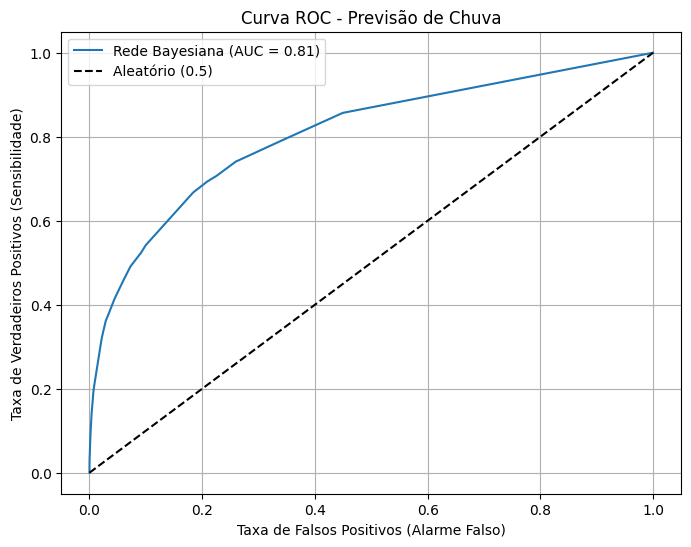

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Obter as probabilidades da classe positiva (1 = Chove)
# O predict_probability retorna um DF. Queremos a coluna correspondente ao '1'.
y_probs_df = model.predict_probability(x_test)

# Assumindo que a coluna do '1' é a segunda coluna (índice 1)
# Verifique se a ordem das colunas é [0, 1] no seu output
probs_chuva = y_probs_df.iloc[:, 1]

# 2. Calcular a Curva ROC
# fpr: False Positive Rate (Taxa de Alarme Falso)
# tpr: True Positive Rate (Taxa de Verdadeiro Positivo / Recall)
# thresholds: Os pontos de corte testados
fpr, tpr, thresholds = roc_curve(y_test, probs_chuva)

# 3. Calcular a AUC (Área Sob a Curva) - Sua "Nota Final"
auc_score = roc_auc_score(y_test, probs_chuva)
print(f"AUC Score: {auc_score:.4f}")

# 4. Plotar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Rede Bayesiana (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (0.5)') # Linha de base
plt.xlabel('Taxa de Falsos Positivos (Alarme Falso)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
plt.title('Curva ROC - Previsão de Chuva')
plt.legend()
plt.grid()
plt.show()

## Otimização das probs

In [ ]:
import numpy as np

# Calcula o J statistic para cada ponto da curva
J = tpr - fpr
ix = np.argmax(J) # Índice do maior J
best_thresh = thresholds[ix]

print(f"Melhor Threshold (Youden): {best_thresh}")
print(f"Sensibilidade neste ponto: {tpr[ix]}")
print(f"Taxa de Alarme Falso neste ponto: {fpr[ix]}")

y_pred_otimizado = (probs_chuva >= best_thresh).astype(int)
print(classification_report(y_test, y_pred_otimizado))

Melhor Threshold (Youden): 0.23807495741056217
Sensibilidade neste ponto: 0.6931942919868277
Taxa de Alarme Falso neste ponto: 0.20885163632480913
